In [1]:
import pandas as pd
import numpy as np
from transformers import T5Tokenizer, T5EncoderModel, EsmTokenizer, EsmModel
import torch
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import joblib
from collections import Counter

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix

In [4]:
df = pd.read_csv('./Datasets/My_Dataset/proteins_df_annotated.csv', index_col=0)
uniprot_id = list(df.uniprot_id.unique())

In [5]:
# remove sequences with length > 1024 and sequences with no IBS

valid_seq = []
for seq in df.sequence.unique():
    if len(seq) < 1024 and sum(df[df.sequence == seq].is_IBS.values) != 0:
      valid_seq.append(df[df.sequence == seq].uniprot_id.unique()[0])

df = df[df.uniprot_id.isin(valid_seq)]

#### Sum of weight function

In [4]:
def calc_labels_and_weight(attention, y, attention_threshold):
  sum_attention_labels = 0
  sum_attention = 0
  for i in range(0, attention.shape[0]):
    for j in range(0, attention.shape[1]):
      # if attention weight is greater than threshold, it means that it is high-confidence attention
      if attention[i][j] > attention_threshold:
        sum_attention_labels += y[j] * attention[i][j]
        sum_attention += attention[i][j]

  return sum_attention_labels, sum_attention

### protTrans model - prot_t5_xl_half_uniref50-enc

In [2]:
############### load model ###############

# For feature extraction we recommend to use the encoder embedding
# Load ProtT5 in half-precision (more specifically: the encoder-part of ProtT5-XL-U50) 
tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)

model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc", torch_dtype=torch.float16)
# Currently (06/2022) half-precision models cannot be used on CPU. If you want to use the encoder only version on CPU, you need to cast it to its full-precision version (model=model.float())
model=model.float()

In [6]:
proteins_with_seq = df[['uniprot_id', 'sequence']].groupby('uniprot_id').apply(lambda x: list(np.unique(x['sequence']))[0].replace('U','X').replace('Z','X').replace('O','X')).to_dict()
results = dict()

is_logistic = True
# read proteins from json file - Logistic Regression
if is_logistic:
  file = open('./attentions/proteins_logistic.json')
  proteins = json.load(file)
  file.close()
else:
  # read proteins from json file - Mathematical Model
  file = open('./attentions/attention_head_results.json')
  proteins = list(json.load(file)['proteins'][0].keys())
  file.close()

for seq_idx, (pdb_id, seq) in tqdm(enumerate(proteins_with_seq.items())):
  seq = seq
  seq_len = len(seq)
  seq = ' '.join(list(seq)) # add space between each AA

  if pdb_id in proteins['test'] and is_logistic:
  # if pdb_id in proteins:
    token_encoding = tokenizer(seq, return_tensors='pt')
    # token_encoding = tokenizer(seq, return_tensors='pt', padding='max_length', truncation=True, max_length=2000)

    try:
      with torch.no_grad():
        embedding_repr = model(**token_encoding, output_attentions=True)
    except RuntimeError:
      print("RuntimeError during embedding for {} (L={})".format(pdb_id, seq_len))
      continue

    results[pdb_id] = embedding_repr

309it [00:20, 14.99it/s]


In [7]:
results.keys()

dict_keys(['A3DK57', 'A4I5U9', 'A6KXE5', 'A6L916', 'A6LIT8'])

In [9]:
df[df.uniprot_id == 'A3DK57'].sequence.unique()[0]

'MRKRKLGFSAVIFITIIAIFGCFLDLRISAAPNEYKFDFGAGPVEPGYIGVSASTAYSKSRGYGFNTPWNMRDVAASGSGLTSDAVQFLTYGTKSENTFNVDLDNGLYEVKVTLGNTSRASVAAEGVYQIINMTGNCATDKFQIPITDGQLNILVTAGKEGTPFTLSALEIRKISDVPVTNRTIYIGGDSTVCNYYPLDTSAQAGWGQMLHKFVDTNVFQIRNMASSGQFARGFRDDGQFEAIMKYLKPGDIFILQFGINDTNSKNSTTEAQFKEIMTDMVVKAKATGATVVLSTPQGRATDFNSSNVHDSQGRWYRRATIEVAREQGVRLVDLNVLSSAYFTSIGPEATLALYMPGDTLHPNREGATQLARIVAEELADLLKAPVATPTSGPSATPTPIPNSFIYGDVNGNGSIESTDCVWVKRYLLKQIDSFPNENGARAADVNGNGTIDSTDYQLLKRFILKVINEFPVQKQKNEPVIYQAEDAIIYNAILETVNAGYTGSCYVNYHNEVGGYIEWNVNAPSSGSYALIFRYANGTTANRPMRITVNGNIVKPSMDFVSTGAWTTWNEAGIVANLNQGNNVIRATAIASDGGPNVDYLKVFSANAFQPVSEEKITIYIAGDSTVQTYNASYAPQAGWGQFLGQYFTSNVVIENRAIAGRSSRSFVEEGRLDSILSVIKPGDYLFIQFGHNDADISKPERYSAPYTTYKEYLRKYVDGARQKGAIPVLITPVARLNYKNNAFVNDFPDYCTAMKQVAEEKNVKLIDLMTKSLNYYNSIGYNETYKLFMVSVNNTDYTHFTEKGAQQIARLVAQGVKEANLDIAKYLKTN'

In [8]:
# layers are 24 -> # of hidden layers [attentions[0:23] are the self-attention layers]
# [ batch_size, num_attention_heads , seq_len + 1, seq_len + 1 ]
# the +2 are the SEP, CLS tokens -> [:max_seq_len - 2]
pr = 'A3DK57'
print(len(results[pr].attentions))
print(results[pr].attentions[0].shape)
print(results[pr].attentions[0][:,0,:-1,:-1].shape)
print(results[pr].attentions[0][:,0,:,:])
# print(results[pr].attentions[1][:,0,:,:].detach().cpu().numpy().squeeze())

24
torch.Size([1, 32, 832, 832])
torch.Size([1, 831, 831])
tensor([[[4.2395e-05, 7.5528e-05, 5.2556e-04,  ..., 9.1941e-04,
          9.4561e-04, 2.5382e-03],
         [3.2223e-05, 9.3920e-06, 2.6272e-04,  ..., 8.2004e-04,
          8.5428e-04, 1.7916e-03],
         [2.4855e-06, 7.7039e-06, 4.5867e-05,  ..., 8.3666e-04,
          2.9673e-04, 2.8818e-03],
         ...,
         [1.0623e-03, 1.8666e-04, 1.4364e-03,  ..., 1.6277e-03,
          8.0372e-03, 7.7264e-03],
         [1.3858e-03, 3.0287e-04, 1.9634e-03,  ..., 1.2281e-03,
          7.4334e-04, 1.3665e-02],
         [1.3865e-04, 3.4428e-05, 7.2357e-05,  ..., 6.7438e-06,
          1.0696e-05, 3.5836e-01]]])


#### Logistic Regression

In [ ]:
def mostCommon(lst):
  return [Counter(col).most_common(1)[0][0] for col in zip(*lst)]

##### Prepare files

In [6]:
### prepapre data for training - export each protein to a csv file

col_names = []
# make column names
for i in range(24):
  for j in range(32):
    col_names.append(f"{i}_{j}")

for pdb_id in tqdm(results.keys()):
  ibs = df[df.uniprot_id == pdb_id].is_IBS.values

  # create a temporary dataframe with number of rows = seq_len * seq_len -> for each combination of positions
  temp_df = pd.DataFrame(columns=col_names)

  # add attention scores
  for layer in range(24):
    for head in range(32):
      temp_df[str(layer) + "_" + str(head)] = results[pdb_id].attentions[layer][:,head,:-1,:-1].detach().cpu().numpy().squeeze().flatten().astype(np.float16)

  # combine weight & target values into one dataframe and save to csv
  pd.concat([temp_df, pd.DataFrame({'target': np.tile(ibs.reshape(-1,1), (len(ibs), 1)).reshape(-1,1).squeeze()})], axis=1).to_csv("./attentions/protTrans/" + pdb_id + ".csv")

100%|██████████| 5/5 [54:33<00:00, 654.77s/it]


In [7]:
# combine all csv files into one dataframe
file = open('./attentions/proteins_logistic.json')
proteins = json.load(file)
file.close()

# get all csv files
csv_files = glob.glob("./attentions/protTrans/*.csv")

# create a list of dataframes
df_list = []

type_set = 'val_dreamm'
# loop through all csv files
for filename in tqdm(csv_files):
  # add column with protein name
  protein = filename.split("/")[-1].split(".")[0]
  if protein not in proteins[type_set]:
    continue

  temp_df = pd.read_csv(filename)
  temp_df['uniprot_id'] = protein
  df_list.append(temp_df)
  
del temp_df
# concatenate all dataframes into one dataframe
df = pd.concat(df_list, ignore_index=True)
df.drop(columns=['Unnamed: 0'], axis = 1, inplace = True)
df.to_csv('./attentions/attention_weights_' + type_set +'_protTrans.csv', index=False)

100%|██████████| 30/30 [01:03<00:00,  2.12s/it]


#### Train Model

In [ ]:
df_train1 = pd.read_csv('attention_weights_train_protTrans1.csv')
df_train2 = pd.read_csv('attention_weights_train_protTrans2.csv')
df_test = pd.read_csv('attention_weights_test_protTrans.csv')

# convert all columns to float16
y_train1 = df_train1['target']
y_train2 = df_train2['target']
y_test = df_test['target']
#y_labels = df_train['uniprot_id']
df_train1.drop(['target', 'uniprot_id'], axis=1, inplace=True)
df_train1 = df_train1.astype(np.float16)

df_train2.drop(['target', 'uniprot_id'], axis=1, inplace=True)
df_train2 = df_train2.astype(np.float16)

clf_sgd = SGDClassifier(
    loss='log_loss', 
    penalty='l1', 
    class_weight={0: 0.52792312, 1: 7.45315418},
    n_jobs=-1, 
    random_state=42
)

# Fit the model to the training data in mini-batches - protTrans
clf_sgd.partial_fit(df_train1, y_train1, classes=[0, 1])
clf_sgd.partial_fit(df_train2, y_train2, classes=[0, 1])

In [ ]:
heat_map = np.zeros((24, 32)) # protTrans

layer = 0
head = 0
for coe in clf_sgd.coef_[0]:
    if head == 31: # protTrans
        heat_map[layer][head] = abs(coe)
        head = 0
        layer +=1
    else:
        heat_map[layer][head] = abs(coe)
        head += 1

ax = sns.heatmap(heat_map, cmap="Blues", linewidth=.5, fmt=".2f%", cbar=False)
ax.invert_yaxis()
cbar = ax.figure.colorbar(ax.collections[0])
cbar.set_ticks([i for i in range(0, int(round(heat_map.max(), -1) + 10), 5)])
cbar.set_ticklabels([str(i) + "" for i in range(0, int(round(heat_map.max(), -1) + 10), 5)])

plt.xlabel('Attention head')
plt.ylabel('Hidden layer')
plt.title('Coefficients of SGD (stochastic gradient descent)')
plt.show()

In [ ]:
### Evaluate the model on the test set
threshold = 0.5

# predict the test data
y_pred = clf_sgd.predict(df_test.drop(['target', 'uniprot_id'], axis=1, inplace=False))
y_pred_proba = clf_sgd.predict_proba(df_test.drop(['target', 'uniprot_id'], axis=1, inplace=False))

# contruct a dataframe with the predictions
df_proteins = pd.DataFrame(columns=['y_true', 'uniprot_id', 'y_pred', 'y_pred_proba'])
df_proteins['y_true'] = df_test['target']
df_proteins['uniprot_id'] = df_test['uniprot_id']
df_proteins['y_pred'] = y_pred
df_proteins['y_pred_proba'] = y_pred_proba[:,1]


y_true_final = []
y_pred_final = []

for protein in df_proteins.uniprot_id.unique():
  target_prot = df_proteins[df_proteins.uniprot_id == protein].y_true

  seq_len = int(np.sqrt(len(target_prot)))

  # convert to the appropriate shape -> seq_len x seq_len
  target_prot_true = np.array(target_prot).reshape(seq_len,int(len(target_prot)/seq_len))
  y_pred_arr = np.array(df_proteins[df_proteins.uniprot_id == protein].y_pred).reshape(seq_len,int(len(df_proteins[df_proteins.uniprot_id == protein].y_pred)/seq_len))
  y_pred_arr_proba = np.array(df_proteins[df_proteins.uniprot_id == protein].y_pred_proba).reshape(seq_len,int(len(df_proteins[df_proteins.uniprot_id == protein].y_pred_proba)/seq_len))

  y_true_final = np.concatenate((y_true_final, mostCommon(target_prot_true)))
  y_pred_final = np.concatenate((y_pred_final, ((y_pred_arr_proba.mean(axis=0) > threshold) + 0)))

print('F1 score: %.3f ' % f1_score(y_true_final, y_pred_final))
print('MCC: %.3f ' % matthews_corrcoef(y_true_final, y_pred_final))
print('Balanced accuracy: %.3f ' % balanced_accuracy_score(y_true_final, y_pred_final))

cm = confusion_matrix(y_true_final, y_pred_final)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

#### Predict proteins

In [3]:
# load model
clf_sgd = joblib.load("./attentions/models/model_protTrans.pkl")

dataset = 'val_dreamm'
df_test = pd.read_csv(f'./attentions/attention_weights_{dataset}_protTrans.csv')
y_test = df_test['target']
threshold = 0.5

# predict the test data
y_pred = clf_sgd.predict(df_test.drop(['target', 'uniprot_id'], axis=1, inplace=False))
y_pred_proba = clf_sgd.predict_proba(df_test.drop(['target', 'uniprot_id'], axis=1, inplace=False))

# contruct a dataframe with the true values & predictions of dataset proteins
df_proteins = pd.DataFrame(columns=['y_true', 'uniprot_id', 'y_pred', 'y_pred_proba'])
df_proteins['y_true'] = df_test['target']
df_proteins['uniprot_id'] = df_test['uniprot_id']
df_proteins['y_pred'] = y_pred
df_proteins['y_pred_proba'] = y_pred_proba[:,1]

prot = {}
for protein in df_proteins.uniprot_id.unique():
  target_prot = df_proteins[df_proteins.uniprot_id == protein].y_true

  seq_len = int(np.sqrt(len(target_prot)))

  target_prot_true = np.array(target_prot).reshape(seq_len,int(len(target_prot)/seq_len))
  y_pred_arr = np.array(df_proteins[df_proteins.uniprot_id == protein].y_pred).reshape(seq_len,int(len(df_proteins[df_proteins.uniprot_id == protein].y_pred)/seq_len))
  y_pred_arr_proba = np.array(df_proteins[df_proteins.uniprot_id == protein].y_pred_proba).reshape(seq_len,int(len(df_proteins[df_proteins.uniprot_id == protein].y_pred_proba)/seq_len))

  prot[protein] = (y_pred_arr_proba.mean(axis=0) > threshold) + 0

/Users/dparanou/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SGDClassifier from version 1.2.0 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


#### Sum of weights

In [ ]:
att_maps = {}
thresholds = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5]

for threshold in thresholds:
  print('Threshold: ' + str(threshold))
  attention_scores = {}
  for hl in range(24): # hidden layers
    print('Layer ' + str(hl))
    for ah in range(32): # attention heads
      sum_attention_weights_labels = 0
      sum_attention_weights = 0

      for pdb_id in results.keys():
        # calculate the denominator of the proportion

        X = results[pdb_id].attentions[hl][0, ah,:-1,:-1].numpy()
        y = df[df.uniprot_id == pdb_id].is_IBS.values

        # calculate the numerator of the proportion
        sum_weights_labels, sum_weights = calc_labels_and_weight(X, y, threshold)
        sum_attention_weights += sum_weights
        sum_attention_weights_labels += sum_weights_labels

      if sum_attention_weights != 0:
        attention_scores[str(hl) + '_' + str(ah)] = (sum_attention_weights_labels / sum_attention_weights) * 100
      else:
        attention_scores[str(hl) + '_' + str(ah)] = 0
  
  att_maps[threshold] = attention_scores

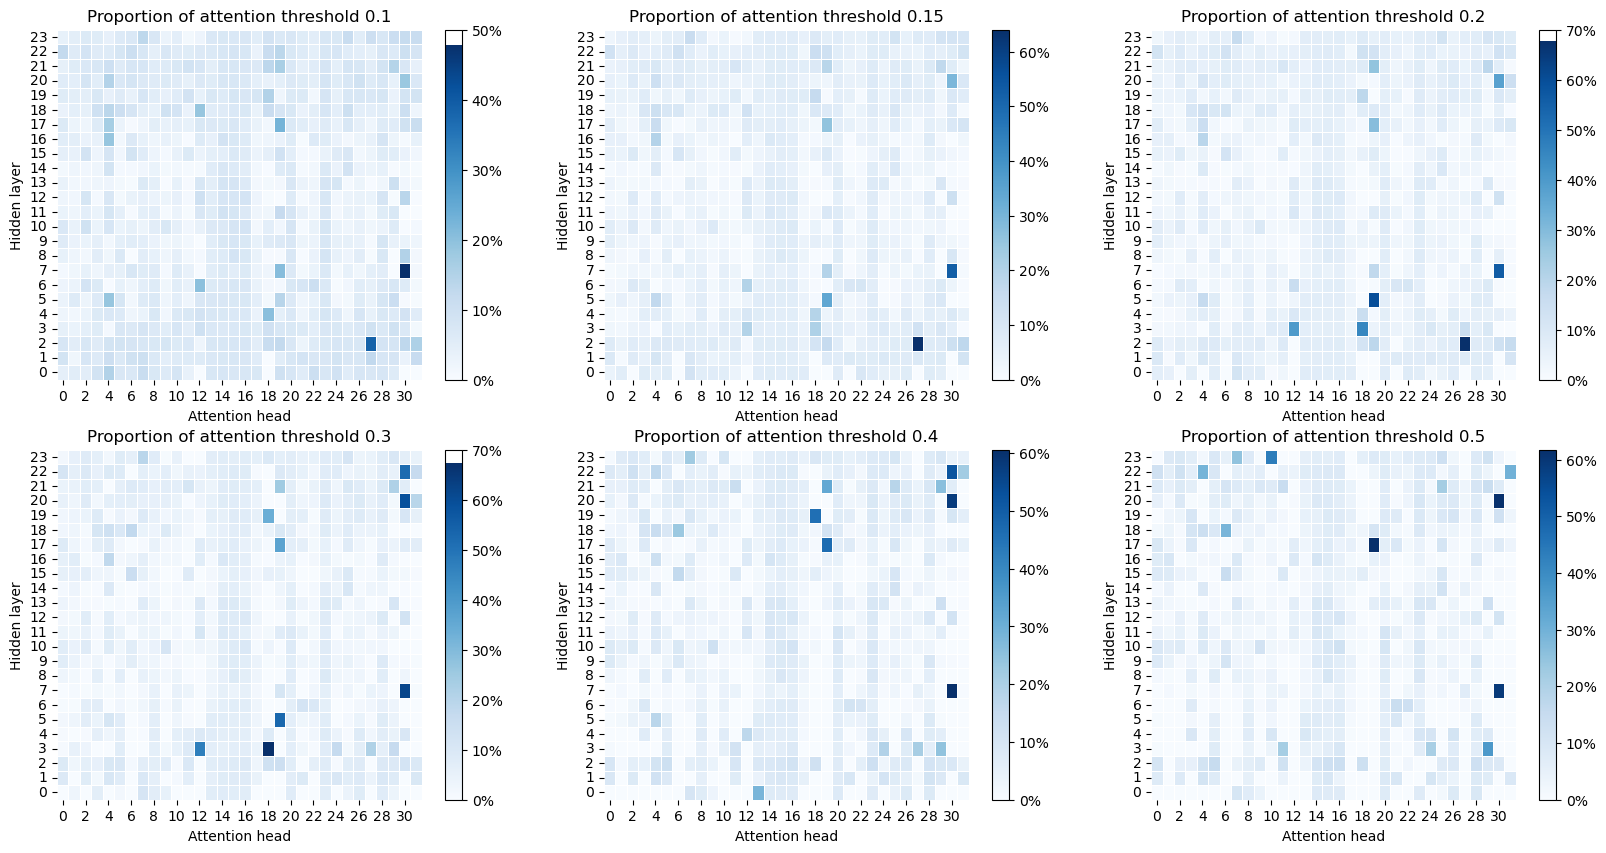

In [16]:
f = open('./attentions/attention_head_results.json')
attention_results = json.load(f)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for index, (thres, values) in enumerate(attention_results['protTrans'].items()):
  attention_scores_2d_array = np.zeros((24, 32))

  if index < 3:
    row = 0
    col = index
  else:
    row = 1
    col = index - 3
  
  for key in values[0].keys():
    attention_scores_2d_array[int(key.split('_')[0])][int(key.split('_')[1])] = values[0][key]
  
  ax = sns.heatmap(attention_scores_2d_array, cmap="Blues", linewidth=.5, fmt=".2f%", cbar=False, ax=axs[row, col])
  ax.invert_yaxis()
  cbar = ax.figure.colorbar(ax.collections[0])
  cbar.set_ticks([i for i in range(0, int(round(attention_scores_2d_array.max(), -1) + 10), 10)])
  cbar.set_ticklabels([str(i) + "%" for i in range(0, int(round(attention_scores_2d_array.max(), -1) + 10), 10)])
  axs[row, col].set_xlabel('Attention head')
  axs[row, col].set_ylabel('Hidden layer')
  axs[row, col].set_title('Proportion of attention threshold ' + str(thres))

plt.show()

### ESM model - esm2_t33_650M_UR50D

In [3]:
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D", do_lower_case=False)

model = EsmModel.from_pretrained("facebook/esm2_t33_650M_UR50D")

Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'esm.contact_head.regression.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'esm.contact_head.regression.bias']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this mode

In [6]:
proteins_with_seq = df[['uniprot_id', 'sequence']].groupby('uniprot_id').apply(lambda x: list(np.unique(x['sequence']))[0].replace('U','X').replace('Z','X').replace('O','X')).to_dict()
results = dict()

is_logistic = True
# read proteins from json file - Logistic Regression
if is_logistic:
  file = open('./attentions/proteins_logistic.json')
  proteins = json.load(file)
  file.close()
else:
  # read proteins from json file - Mathematical Model
  file = open('./attentions/attention_head_results.json')
  proteins = list(json.load(file)['proteins'][0].keys())
  file.close()

for seq_idx, (pdb_id, seq) in tqdm(enumerate(proteins_with_seq.items())):
  seq = seq
  seq_len = len(seq)

  if pdb_id not in proteins['val_dreamm'] and is_logistic:
    continue
  
  # add_special_tokens adds extra token at the end of each sequence
  token_encoding = tokenizer(seq, return_tensors="pt")

  try:
    with torch.no_grad():
      # returns: ( batch-size x max_seq_len_in_minibatch x embedding_dim )
      embedding_repr = model(input_ids=token_encoding['input_ids'], attention_mask=token_encoding['attention_mask'], output_attentions=True)
  except RuntimeError:
    print("RuntimeError during embedding for {} (L={})".format(pdb_id, seq_len))
    continue
  
  results[pdb_id] = embedding_repr

443it [00:06, 64.78it/s]


In [ ]:
# attentions are 33 -> # of hidden layers [attentions[0:32] are the self-attention layers]
# [ x, num_attention_heads , seq_len + 2, seq_len + 2 ]
# the +2 are the SEP, CLS tokens -> [:max_seq_len - 2]
print(len(results['A0A6N4SPL7'].attentions))
print(results['A0A6N4SPL7'].attentions[0].shape)
print(results['A0A6N4SPL7'].attentions[0][0,0,1:-1,1:-1].shape)
print(results['A0A6N4SPL7'].attentions[1][:,0,:,:].detach().cpu().numpy().squeeze())

#### Logistic Regression

##### Prepare files

In [8]:
### prepapre data for training - export each protein to a csv file

col_names = []
# make column names
for i in range(33):
  for j in range(20):
    col_names.append(f"{i}_{j}")

for pdb_id in results.keys():
  ibs = df[df.uniprot_id == pdb_id].is_IBS.values

  # create a temporary dataframe with number of rows = seq_len * seq_len -> for each combination of positions
  temp_df = pd.DataFrame(columns=col_names)

  # add attention scores
  for layer in range(33):
    for head in range(20):
      temp_df[str(layer) + "_" + str(head)] = results[pdb_id].attentions[layer][:,head,1:-1,1:-1].detach().cpu().numpy().squeeze().flatten().astype(np.float16)

  # combine weight & target values into one dataframe and save to csv
  pd.concat([temp_df, pd.DataFrame({'target': np.tile(ibs.reshape(-1,1), (len(ibs), 1)).reshape(-1,1).squeeze()})], axis=1).to_csv("./attentions/ESM/" + pdb_id + ".csv")

In [9]:
# combine all csv files into one dataframe
file = open('./attentions/proteins_logistic.json')
proteins = json.load(file)
file.close()

# get all csv files
csv_files = glob.glob("./attentions/ESM/*.csv")

# create a list of dataframes
df = pd.DataFrame()

type_set = 'val_dreamm'
# loop through all csv files
for filename in csv_files:
  # add column with protein name
  temp_df = pd.read_csv(filename)
  if filename.split("/")[-1].split(".")[0] not in proteins[type_set]:
    continue
  temp_df['uniprot_id'] = filename.split("/")[-1].split(".")[0]
  df = df.append(temp_df, ignore_index=True)

df = df.drop(columns=['Unnamed: 0'])
df.to_csv('./attentions/attention_weights_' + type_set +'_esm.csv', index=False)

/var/folders/rw/9j5794s503z4wklybl6pd58c0000gn/T/ipykernel_1118/1943782452.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df, ignore_index=True)
/var/folders/rw/9j5794s503z4wklybl6pd58c0000gn/T/ipykernel_1118/1943782452.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df, ignore_index=True)
/var/folders/rw/9j5794s503z4wklybl6pd58c0000gn/T/ipykernel_1118/1943782452.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df, ignore_index=True)
/var/folders/rw/9j5794s503z4wklybl6pd58c0000gn/T/ipykernel_1118/1943782452.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df 

##### Train model

In [ ]:
df_train = pd.read_csv('attention_weights_train_esm.csv')
df_test = pd.read_csv('attention_weights_esm.csv')

# convert all columns to float16
y_train = df_train['target']
y_test = df_test['target']
# y_labels = df_train['uniprot_id']
df_train.drop(['target', 'uniprot_id'], axis=1, inplace=True)
df_train = df_train.astype(np.float16)

clf_sgd = SGDClassifier(
    loss='log_loss', 
    penalty='l1', 
    # alpha=1/0.15,
    class_weight="balanced",
    n_jobs=-1, 
    random_state=42
)

clf_sgd.fit(df_train, y_train)

In [ ]:
heat_map = np.zeros((33, 20)) # ESM

layer = 0
head = 0
for coe in clf_sgd.coef_[0]:
    if head == 19: # ESM
        heat_map[layer][head] = abs(coe)
        head = 0
        layer +=1
    else:
        heat_map[layer][head] = abs(coe)
        head += 1

ax = sns.heatmap(heat_map, cmap="Blues", linewidth=.5, fmt=".2f%", cbar=False)
ax.invert_yaxis()
cbar = ax.figure.colorbar(ax.collections[0])
cbar.set_ticks([i for i in range(0, int(round(heat_map.max(), -1) + 10), 5)])
cbar.set_ticklabels([str(i) + "" for i in range(0, int(round(heat_map.max(), -1) + 10), 5)])

plt.xlabel('Attention head')
plt.ylabel('Hidden layer')
plt.title('Coefficients of SGD (stochastic gradient descent)')
plt.show()

In [ ]:
### Evaluate the model on the test set
threshold = 0.5

# predict the test data
y_pred = clf_sgd.predict(df_test.drop(['target', 'uniprot_id'], axis=1, inplace=False))
y_pred_proba = clf_sgd.predict_proba(df_test.drop(['target', 'uniprot_id'], axis=1, inplace=False))

# contruct a dataframe with the predictions
df_proteins = pd.DataFrame(columns=['y_true', 'uniprot_id', 'y_pred', 'y_pred_proba'])
df_proteins['y_true'] = df_test['target']
df_proteins['uniprot_id'] = df_test['uniprot_id']
df_proteins['y_pred'] = y_pred
df_proteins['y_pred_proba'] = y_pred_proba[:,1]


y_true_final = []
y_pred_final = []

for protein in df_proteins.uniprot_id.unique():
  target_prot = df_proteins[df_proteins.uniprot_id == protein].y_true

  seq_len = int(np.sqrt(len(target_prot)))

  # convert to the appropriate shape -> seq_len x seq_len
  target_prot_true = np.array(target_prot).reshape(seq_len,int(len(target_prot)/seq_len))
  y_pred_arr = np.array(df_proteins[df_proteins.uniprot_id == protein].y_pred).reshape(seq_len,int(len(df_proteins[df_proteins.uniprot_id == protein].y_pred)/seq_len))
  y_pred_arr_proba = np.array(df_proteins[df_proteins.uniprot_id == protein].y_pred_proba).reshape(seq_len,int(len(df_proteins[df_proteins.uniprot_id == protein].y_pred_proba)/seq_len))

  y_true_final = np.concatenate((y_true_final, mostCommon(target_prot_true)))
  y_pred_final = np.concatenate((y_pred_final, ((y_pred_arr_proba.mean(axis=0) > threshold) + 0)))

print('F1 score: %.3f ' % f1_score(y_true_final, y_pred_final))
print('MCC: %.3f ' % matthews_corrcoef(y_true_final, y_pred_final))
print('Balanced accuracy: %.3f ' % balanced_accuracy_score(y_true_final, y_pred_final))

cm = confusion_matrix(y_true_final, y_pred_final)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

#### Predict Proteins

In [15]:
# load model
clf_sgd = joblib.load("./attentions/models/model_esm.pkl")

dataset = 'val_dreamm'
df_test = pd.read_csv(f'./attentions/attention_weights_{dataset}_esm.csv')
y_test = df_test['target']
threshold = 0.5

# predict the test data
y_pred = clf_sgd.predict(df_test.drop(['target', 'uniprot_id'], axis=1, inplace=False))
y_pred_proba = clf_sgd.predict_proba(df_test.drop(['target', 'uniprot_id'], axis=1, inplace=False))

# contruct a dataframe with the true values & predictions of dataset proteins
df_proteins = pd.DataFrame(columns=['y_true', 'uniprot_id', 'y_pred', 'y_pred_proba'])
df_proteins['y_true'] = df_test['target']
df_proteins['uniprot_id'] = df_test['uniprot_id']
df_proteins['y_pred'] = y_pred
df_proteins['y_pred_proba'] = y_pred_proba[:,1]

prot = {}
for protein in df_proteins.uniprot_id.unique():
  target_prot = df_proteins[df_proteins.uniprot_id == protein].y_true

  seq_len = int(np.sqrt(len(target_prot)))

  target_prot_true = np.array(target_prot).reshape(seq_len,int(len(target_prot)/seq_len))
  y_pred_arr = np.array(df_proteins[df_proteins.uniprot_id == protein].y_pred).reshape(seq_len,int(len(df_proteins[df_proteins.uniprot_id == protein].y_pred)/seq_len))
  y_pred_arr_proba = np.array(df_proteins[df_proteins.uniprot_id == protein].y_pred_proba).reshape(seq_len,int(len(df_proteins[df_proteins.uniprot_id == protein].y_pred_proba)/seq_len))

  prot[protein] = (y_pred_arr_proba.mean(axis=0) > threshold) + 0

#### Sum of weights

In [ ]:
att_maps = {}
thresholds = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5]

for threshold in thresholds:
  print('Threshold: ' + str(threshold))
  attention_scores = {}
  for hl in range(33): # hidden layers
    print('Layer ' + str(hl))
    for ah in range(20): # attention heads
      sum_attention_weights_labels = 0
      sum_attention_weights = 0

      for pdb_id in results.keys():
        # calculate the denominator of the proportion

        X = results[pdb_id].attentions[hl][0, ah,1:-1,1:-1].numpy()
        y = df[df.uniprot_id == pdb_id].is_IBS.values

        # calculate the numerator of the proportion
        sum_weights_labels, sum_weights = calc_labels_and_weight(X, y, threshold)
        sum_attention_weights += sum_weights
        sum_attention_weights_labels += sum_weights_labels

      if sum_attention_weights != 0:
        attention_scores[str(hl) + '_' + str(ah)] = (sum_attention_weights_labels / sum_attention_weights) * 100
      else:
        attention_scores[str(hl) + '_' + str(ah)] = 0
  
  att_maps[threshold] = attention_scores

In [ ]:
f = open('attention_head_results.json')
attention_results = json.load(f)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for index, (thres, values) in enumerate(attention_results['ESM'].items()):
  attention_scores_2d_array = np.zeros((34, 20))

  if index < 3:
    row = 0
    col = index
  else:
    row = 1
    col = index - 3
  
  for key in values[0].keys():
    attention_scores_2d_array[int(key.split('_')[0])][int(key.split('_')[1])] = values[0][key]
  
  ax = sns.heatmap(attention_scores_2d_array, cmap="Blues", linewidth=.5, fmt=".2f%", cbar=False, ax=axs[row, col])
  ax.invert_yaxis()
  cbar = ax.figure.colorbar(ax.collections[0])
  cbar.set_ticks([i for i in range(0, int(round(attention_scores_2d_array.max(), -1) + 10), 10)])
  cbar.set_ticklabels([str(i) + "%" for i in range(0, int(round(attention_scores_2d_array.max(), -1) + 10), 10)])
  axs[row, col].set_xlabel('Attention head')
  axs[row, col].set_ylabel('Hidden layer')
  axs[row, col].set_title('Proportion of attention threshold ' + str(thres))

plt.show()